# CNN

In [2]:
import sys
sys.path.append('/notebooks/MOD2NN')

In [3]:
import os
import json

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

from CNN.module.lib.layers import *
from Faraday.two_dim.module.lib.layers import *

from Faraday.two_dim import matplotlib_style
matplotlib_style.paper()

tf.random.set_seed(1)

print("TensorFlow:", tf.__version__)
print("Python:", sys.version)

plt.rcParams['font.size'] = 18

TensorFlow: 2.9.1
Python: 3.9.13 (main, May 23 2022, 22:01:06) 
[GCC 9.4.0]


In [73]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.sqrt(x_train.astype("float32") / 255.0)
x_test = np.sqrt(x_test.astype("float32") / 255.0)

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-5000:]
y_val = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]

In [74]:
def create_model(shape):
    inputs = tf.keras.Input((28,28))
    x = ImageResizing(shape)(inputs)
    x = layers.Flatten()(x)
    x = Real2Complex()(x)
    x = ComplexDense(10)(x)
    x = MulConjugate()(x)
    x = Real()(x)
    x = tf.keras.layers.Softmax()(x)

    return tf.keras.Model(inputs, x)

In [75]:
def train(i, seed):
    shape = (int(28*i), int(28*i))
    tf.random.set_seed(seed)
    model_name = "20221124/20221124_shape({:d}_{:d})_seed_{:d}_".format(*shape, seed)
    path = "/notebooks/"
    checkpoint_path = path + "checkpoint/" + model_name + "/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    path = path + "trained_model/"+ model_name

    model = create_model(shape)
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # category: sparse_categorical_crossentropy
                  metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=False), "accuracy"]
                  )

    epochs = 30
    early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='loss',
            min_delta=0.0002,
            patience=2,
        )

    def lr_schedule(epoch):
      """
      Returns a custom learning rate that decreases as epochs progress.
      """
      start = 0.2
      end = 0.0001
      n = 50
      a = -1/(n-1) * np.log(end/start)
      x = np.arange(n)
      return np.exp(-a*(epoch-1)) * start
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

    # チェックポイントコールバックを作る
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)

    logdir = os.path.join(path +"logs", model_name)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    result = model.fit(x_train,
                       y_train,
                       batch_size=64,
                       epochs=epochs,
                       validation_data=(x_val, y_val),
                       callbacks=[cp_callback]
                       )

    model.save(path)

    df = pd.DataFrame(result.history)
    df.to_csv(path + "/history.csv")



    with open(path + "/config.json", 'w') as f:
        json.dump(model.get_config(), f, indent=4)

In [31]:
index = [1, 2, 3]
seeds = [1,2,3,4,5]

for i in index:
    for seed in seeds:
        train(i, seed)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_9 (ImageResi  (None, 28, 28)           0         
 zing)                                                           
                                                                 
 flatten_9 (Flatten)         (None, 784)               0         
                                                                 
 real2_complex_8 (Real2Compl  (None, 784)              0         
 ex)                                                             
                                                                 
 complex_dense_8 (ComplexDen  (None, 10)               15680     
 se)                                                             
                                                           

## 追加(14,14)

In [61]:
seeds = [1,2,3,4,5]

for seed in seeds:
    train(0.5, seed)

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_35 (ImageRes  (None, 14, 14)           0         
 izing)                                                          
                                                                 
 flatten_34 (Flatten)        (None, 196)               0         
                                                                 
 real2_complex_33 (Real2Comp  (None, 196)              0         
 lex)                                                            
                                                                 
 complex_dense_33 (ComplexDe  (None, 10)               3920      
 nse)                                                            
                                                          

## 追加(7,7)

In [76]:
seeds = [1,2,3,4,5]

for seed in seeds:
    train(0.25, seed)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 image_resizing (ImageResizi  (None, 7, 7)             0         
 ng)                                                             
                                                                 
 flatten (Flatten)           (None, 49)                0         
                                                                 
 real2_complex (Real2Complex  (None, 49)               0         
 )                                                               
                                                                 
 complex_dense (ComplexDense  (None, 10)               980       
 )                                                               
                                                             

In [7]:
import glob
import re

In [8]:
cmap = plt.get_cmap("tab10")
cmap.colors[0]

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

In [26]:
models = glob.glob("/notebooks/trained_model/20221124/*")
models = [s for s in models if re.match(r'.*(lr_schedule|optimizer).*',s) is None]
models.sort()
os.path.basename(models[0])

eval_list = []

for model in models:
    _model = tf.keras.models.load_model(model)
    eval = _model.evaluate(x_test, y_test)
    eval_list.append([os.path.basename(model), *eval])

test_df = pd.DataFrame(eval_list, columns=["name", "loss", "spars_categorical", "acc"])
test_df.to_csv("./normal_eval.csv")

313/313 [==============================] - 1s 2ms/step - loss: 1.3951 - sparse_categorical_crossentropy: 1.3951 - accuracy: 0.9025


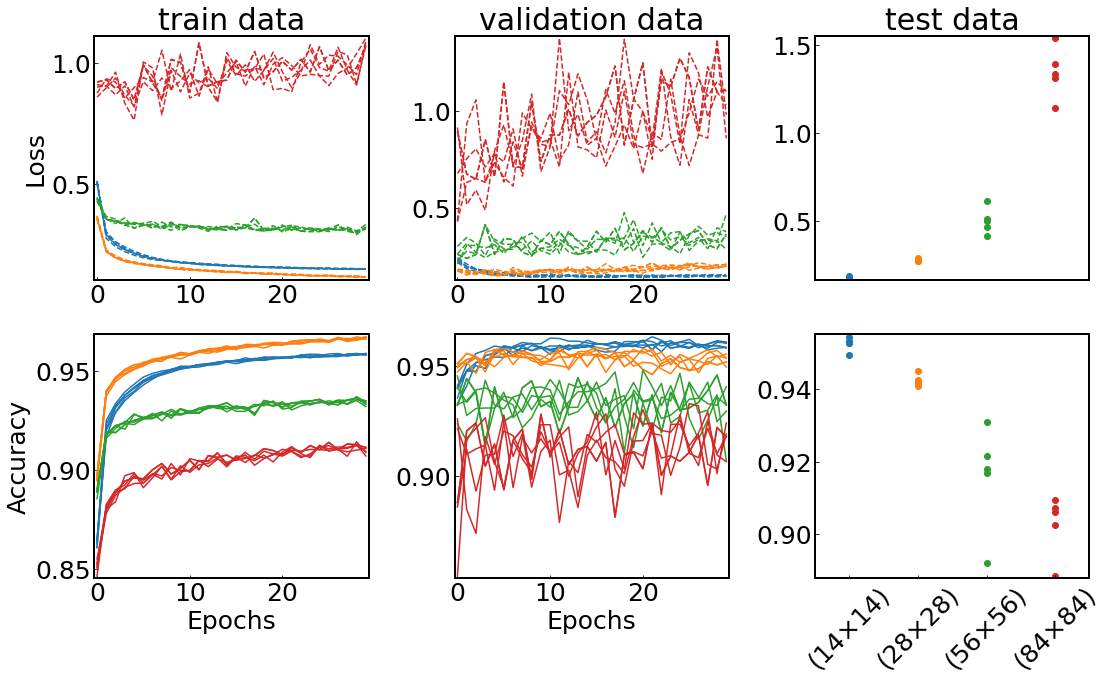

In [54]:
files = glob.glob("/notebooks/trained_model/20221124/*/*.csv")
files.sort()

plt.rcParams['font.size'] = 25
color_dict = {}
index_dict = {}
cmap = plt.get_cmap("tab10")

fig, axes = plt.subplots(2, 3, figsize=(16,10))

for f in files:
    df = pd.read_csv(f)
    shape_group = re.search("shape\(.*\)", f).group()
    if shape_group not in color_dict:
        color_dict[shape_group] = cmap.colors[len(color_dict)]
        axes[0,0].plot(df["loss"], color=color_dict[shape_group], linestyle="--", label=shape_group)
        axes[1,0].plot(df["accuracy"], color=color_dict[shape_group], linestyle="-", label=shape_group)
        axes[0,1].plot(df["val_loss"], color=color_dict[shape_group], linestyle="--", label=shape_group)
        axes[1,1].plot(df["val_accuracy"], color=color_dict[shape_group], linestyle="-", label=shape_group)
        index_dict[shape_group] = len(index_dict)

    axes[0,0].plot(df["loss"], color=color_dict[shape_group], linestyle="--")
    axes[1,0].plot(df["accuracy"], color=color_dict[shape_group], linestyle="-")
    axes[0,1].plot(df["val_loss"], color=color_dict[shape_group], linestyle="--")
    axes[1,1].plot(df["val_accuracy"], color=color_dict[shape_group], linestyle="-")

for row in test_df.values:
    shape_group = re.search("shape\(.*\)", row[0]).group()
    axes[0,2].scatter(index_dict[shape_group], row[1], color=color_dict[shape_group])
    axes[1,2].scatter(index_dict[shape_group], row[3], color=color_dict[shape_group])

axes[0,0].set_ylabel("Loss")
axes[0,0].set_title("train data")
axes[1,0].set_ylabel("Accuracy")

axes[1,0].set_xlabel("Epochs")
axes[0,1].set_title("validation data")
axes[1,1].set_xlabel("Epochs")

axes[0,2].set_xticks([],[])
axes[1,2].set_xticks([0,1,2,3], [re.search(r'\(\d+_\d+\)', key).group().replace("_", "×") for key in list(index_dict.keys())], rotation=45)

axes[0,2].set_xlim(-0.5, 3.5)
axes[0,2].set_title("test data")
axes[1,2].set_xlim(-0.5, 3.5)

fig.tight_layout()

# ラーニングレート調整

In [18]:
def train(i, seed):
    shape = (int(28*i), int(28*i))
    tf.random.set_seed(seed)
    model_name = "20221124/lr_schedule/shape({:d}_{:d})_seed_{:d}_".format(*shape, seed)
    path = "/notebooks/"
    checkpoint_path = path + "checkpoint/" + model_name + "/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    path = path + "trained_model/"+ model_name

    model = create_model(shape)
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # category: sparse_categorical_crossentropy
                  metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=False), "accuracy"]
                  )

    epochs = 30
    early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='loss',
            min_delta=0.0002,
            patience=2,
        )

    def lr_schedule(epoch):
      """
      Returns a custom learning rate that decreases as epochs progress.
      """
      start = 0.1
      end = 0.00001
      n = epochs
      b = -1/(n-1) * np.log(end/start)
      a = start * np.exp(b)
      return a*np.exp(-b*(epoch+1))
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

    # チェックポイントコールバックを作る
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)

    logdir = os.path.join(path +"logs", model_name)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    result = model.fit(x_train,
                       y_train,
                       batch_size=64,
                       epochs=epochs,
                       validation_data=(x_val, y_val),
                       callbacks=[cp_callback, lr_callback]
                       )

    model.save(path)

    df = pd.DataFrame(result.history)
    df.to_csv(path + "/history.csv")



    with open(path + "/config.json", 'w') as f:
        json.dump(model.get_config(), f, indent=4)

In [19]:
index = [0.5, 1, 2, 3]
seeds = [1,2,3,4,5]

for i in index:
    for seed in seeds:
        train(i, seed)

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_20 (ImageRes  (None, 14, 14)           0         
 izing)                                                          
                                                                 
 flatten_20 (Flatten)        (None, 196)               0         
                                                                 
 real2_complex_20 (Real2Comp  (None, 196)              0         
 lex)                                                            
                                                                 
 complex_dense_20 (ComplexDe  (None, 10)               3920      
 nse)                                                            
                                                          

In [62]:
models = glob.glob("/notebooks/trained_model/20221124/lr_schedule/*")
models.sort()
os.path.basename(models[0])

eval_list = []

for model in models:
    _model = tf.keras.models.load_model(model)
    eval = _model.evaluate(x_test, y_test)
    eval_list.append([os.path.basename(model), *eval])

test_df = pd.DataFrame(eval_list, columns=["name", "loss", "spars_categorical", "acc"])
test_df.to_csv("./adam_lr_schedule_eval.csv")

313/313 [==============================] - 1s 2ms/step - loss: 104.4005 - sparse_categorical_crossentropy: 104.4005 - accuracy: 0.9226


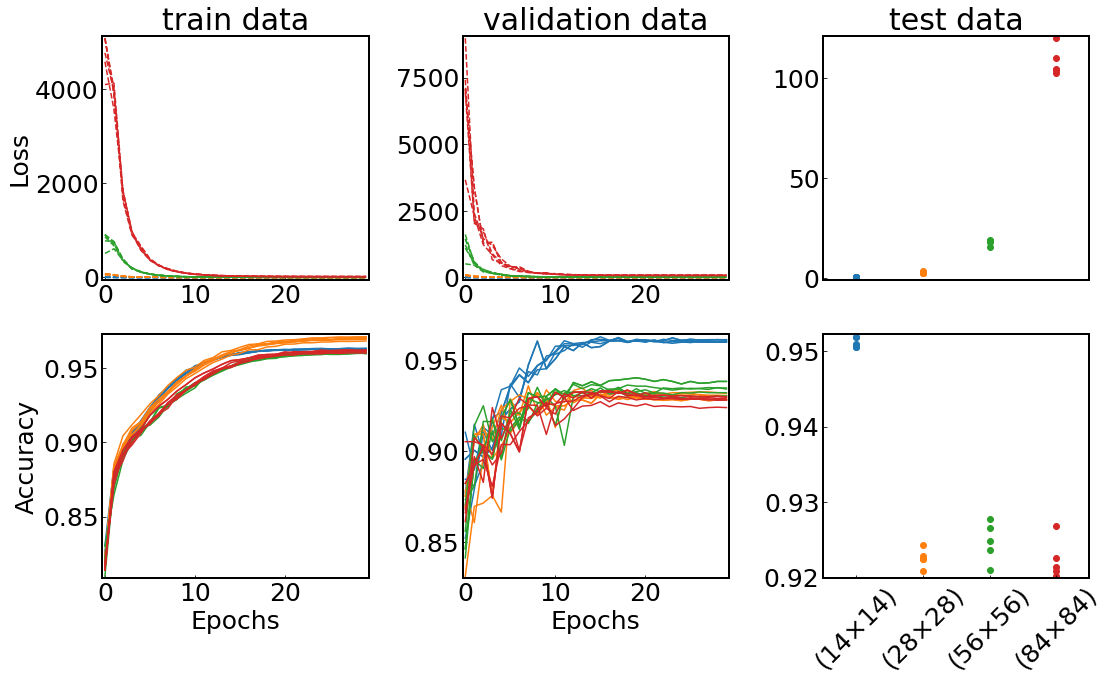

In [63]:
files = glob.glob("/notebooks/trained_model/20221124/lr_schedule/*/*.csv")
files.sort()

plt.rcParams['font.size'] = 25
color_dict = {}
index_dict = {}
cmap = plt.get_cmap("tab10")

fig, axes = plt.subplots(2, 3, figsize=(16,10))

for f in files:
    df = pd.read_csv(f)
    shape_group = re.search("shape\(.*\)", f).group()
    if shape_group not in color_dict:
        color_dict[shape_group] = cmap.colors[len(color_dict)]
        axes[0,0].plot(df["loss"], color=color_dict[shape_group], linestyle="--", label=shape_group)
        axes[1,0].plot(df["accuracy"], color=color_dict[shape_group], linestyle="-", label=shape_group)
        axes[0,1].plot(df["val_loss"], color=color_dict[shape_group], linestyle="--", label=shape_group)
        axes[1,1].plot(df["val_accuracy"], color=color_dict[shape_group], linestyle="-", label=shape_group)
        index_dict[shape_group] = len(index_dict)

    axes[0,0].plot(df["loss"], color=color_dict[shape_group], linestyle="--")
    axes[1,0].plot(df["accuracy"], color=color_dict[shape_group], linestyle="-")
    axes[0,1].plot(df["val_loss"], color=color_dict[shape_group], linestyle="--")
    axes[1,1].plot(df["val_accuracy"], color=color_dict[shape_group], linestyle="-")

for row in test_df.values:
    shape_group = re.search("shape\(.*\)", row[0]).group()
    axes[0,2].scatter(index_dict[shape_group], row[1], color=color_dict[shape_group])
    axes[1,2].scatter(index_dict[shape_group], row[3], color=color_dict[shape_group])

axes[0,0].set_ylabel("Loss")
axes[0,0].set_title("train data")
axes[1,0].set_ylabel("Accuracy")

axes[1,0].set_xlabel("Epochs")
axes[0,1].set_title("validation data")
axes[1,1].set_xlabel("Epochs")

axes[0,2].set_xticks([],[])
axes[1,2].set_xticks([0,1,2,3], [re.search(r'\(\d+_\d+\)', key).group().replace("_", "×") for key in list(index_dict.keys())], rotation=45)

axes[0,2].set_xlim(-0.5, 3.5)
axes[0,2].set_title("test data")
axes[1,2].set_xlim(-0.5, 3.5)

fig.tight_layout()

# オプティマイザー
## RMSprop

In [15]:
def train(i, seed):
    shape = (int(28*i), int(28*i))
    tf.random.set_seed(seed)
    model_name = "20221124/optimizer/RMSprop_shape({:d}_{:d})_seed_{:d}_".format(*shape, seed)
    path = "/notebooks/"
    checkpoint_path = path + "checkpoint/" + model_name + "/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    path = path + "trained_model/"+ model_name

    model = create_model(shape)
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.RMSprop(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # category: sparse_categorical_crossentropy
                  metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=False), "accuracy"]
                  )

    epochs = 30
    early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='loss',
            min_delta=0.0002,
            patience=2,
        )

    def lr_schedule(epoch):
      """
      Returns a custom learning rate that decreases as epochs progress.
      """
      start = 0.2
      end = 0.00001
      n = epochs
      b = -1/(n-1) * np.log(end/start)
      a = start * np.exp(b)
      return a*np.exp(-b*(epoch+1))
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

    # チェックポイントコールバックを作る
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)

    logdir = os.path.join(path +"logs", model_name)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    result = model.fit(x_train,
                       y_train,
                       batch_size=64,
                       epochs=epochs,
                       validation_data=(x_val, y_val),
                       callbacks=[cp_callback]
                       )

    model.save(path)

    df = pd.DataFrame(result.history)
    df.to_csv(path + "/history.csv")



    with open(path + "/config.json", 'w') as f:
        json.dump(model.get_config(), f, indent=4)

In [16]:
index = [0.5, 1, 2, 3]
seeds = [1,2,3,4,5]

for i in index:
    for seed in seeds:
        train(i, seed)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 image_resizing (ImageResizi  (None, 14, 14)           0         
 ng)                                                             
                                                                 
 flatten (Flatten)           (None, 196)               0         
                                                                 
 real2_complex (Real2Complex  (None, 196)              0         
 )                                                               
                                                                 
 complex_dense (ComplexDense  (None, 10)               3920      
 )                                                               
                                                             

In [70]:
models = glob.glob("/notebooks/trained_model/20221124/optimizer/*")
models = [s for s in models if re.match(r'.*RMSprop.*',s) is not None]
models.sort()
os.path.basename(models[0])

eval_list = []

for model in models:
    _model = tf.keras.models.load_model(model)
    eval = _model.evaluate(x_test, y_test)
    eval_list.append([os.path.basename(model), *eval])

test_df = pd.DataFrame(eval_list, columns=["name", "loss", "spars_categorical", "acc"])
test_df.to_csv("./rmsprop.csv")

313/313 [==============================] - 1s 2ms/step - loss: 2.6392 - sparse_categorical_crossentropy: 2.6392 - accuracy: 0.9060


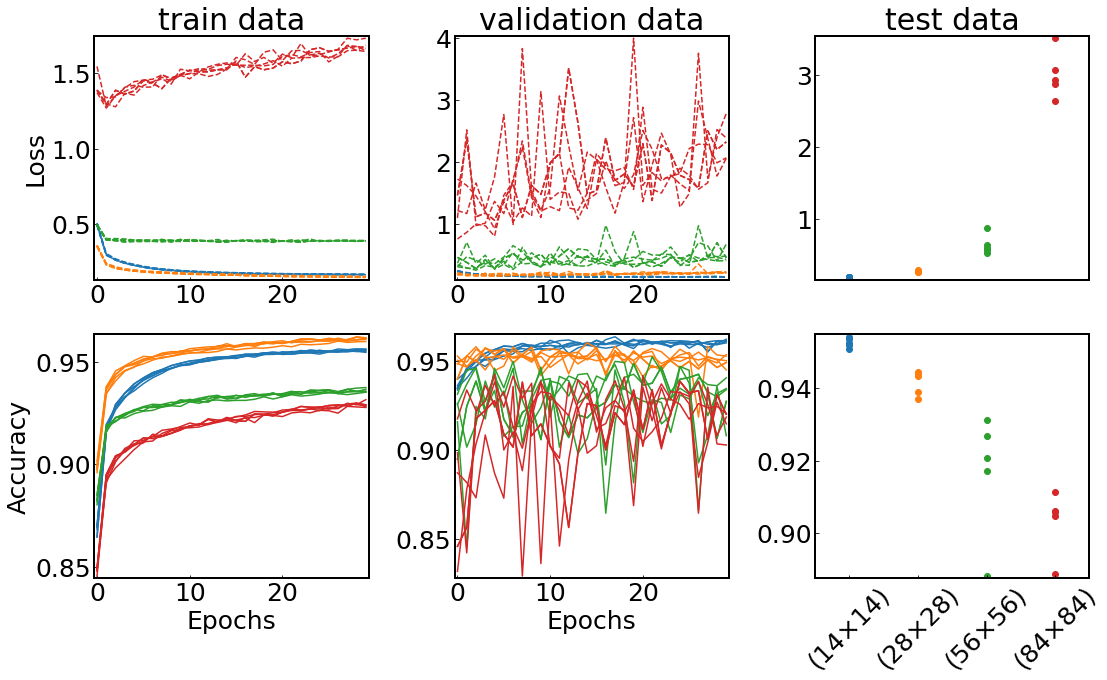

In [72]:
files = glob.glob("/notebooks/trained_model/20221124/optimizer/*/*.csv")
files = [s for s in files if re.match(r'.*RMSprop.*',s) is not None]
files.sort()

plt.rcParams['font.size'] = 25
color_dict = {}
index_dict = {}
cmap = plt.get_cmap("tab10")

fig, axes = plt.subplots(2, 3, figsize=(16,10))

for f in files:
    df = pd.read_csv(f)
    shape_group = re.search("shape\(.*\)", f).group()
    if shape_group not in color_dict:
        color_dict[shape_group] = cmap.colors[len(color_dict)]
        axes[0,0].plot(df["loss"], color=color_dict[shape_group], linestyle="--", label=shape_group)
        axes[1,0].plot(df["accuracy"], color=color_dict[shape_group], linestyle="-", label=shape_group)
        axes[0,1].plot(df["val_loss"], color=color_dict[shape_group], linestyle="--", label=shape_group)
        axes[1,1].plot(df["val_accuracy"], color=color_dict[shape_group], linestyle="-", label=shape_group)
        index_dict[shape_group] = len(index_dict)

    axes[0,0].plot(df["loss"], color=color_dict[shape_group], linestyle="--")
    axes[1,0].plot(df["accuracy"], color=color_dict[shape_group], linestyle="-")
    axes[0,1].plot(df["val_loss"], color=color_dict[shape_group], linestyle="--")
    axes[1,1].plot(df["val_accuracy"], color=color_dict[shape_group], linestyle="-")

for row in test_df.values:
    shape_group = re.search("shape\(.*\)", row[0]).group()
    axes[0,2].scatter(index_dict[shape_group], row[1], color=color_dict[shape_group])
    axes[1,2].scatter(index_dict[shape_group], row[3], color=color_dict[shape_group])

axes[0,0].set_ylabel("Loss")
axes[0,0].set_title("train data")
axes[1,0].set_ylabel("Accuracy")

axes[1,0].set_xlabel("Epochs")
axes[0,1].set_title("validation data")
axes[1,1].set_xlabel("Epochs")

axes[0,2].set_xticks([],[])
axes[1,2].set_xticks([0,1,2,3], [re.search(r'\(\d+_\d+\)', key).group().replace("_", "×") for key in list(index_dict.keys())], rotation=45)

axes[0,2].set_xlim(-0.5, 3.5)
axes[0,2].set_title("test data")
axes[1,2].set_xlim(-0.5, 3.5)

fig.tight_layout()

# テスト正解率比較

In [112]:
adam_test = pd.read_csv("./normal_eval.csv")
acc_list = []
for row in adam_test.values:
    if re.search(".*14_14.*", row[1]) is not None:
        acc_list.append(row[-1])

np.average(acc_list)

0.9525400161743166

In [113]:
adam_test = pd.read_csv("./adam_lr_schedule_eval.csv")
acc_list = []
for row in adam_test.values:
    if re.search(".*14_14.*", row[1]) is not None:
        acc_list.append(row[-1])

np.average(acc_list)

0.9511400103569031

In [114]:
adam_test = pd.read_csv("./rmsprop.csv")
acc_list = []
for row in adam_test.values:
    if re.search(".*14_14.*", row[1]) is not None:
        acc_list.append(row[-1])

np.average(acc_list)

0.9526600122451783

# 結論
大体96%で打ち止め

# 他論文の精度との確認

(-0.5, 4.5)

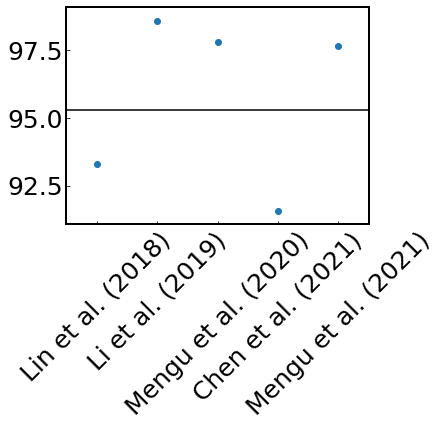

In [118]:
papers_data = {}
papers_data["Lin et al. (2018)"] = 93.29
papers_data["Li et al. (2019)"] = 98.59
papers_data["Mengu et al. (2020)"] = 97.81
papers_data["Chen et al. (2021)"] = 91.57
papers_data["Mengu et al. (2021)"] = 97.64

plt.scatter(range(len(papers_data)), papers_data.values())
plt.hlines(95.3, -0.5, len(papers_data)-0.5, color="black")
plt.xticks(range(len(papers_data)), list(papers_data.keys()), rotation=45)
plt.ylim(min(papers_data.values())-0.5, max(papers_data.values())+0.5)
plt.xlim(-0.5, len(papers_data)-0.5)